***
### Tutorial to load a keras model with custom layer(s):

This notebook can be used to load the model with custom layer using the function `loading_pruned_model` available in the package. The necessary imports can be installed using the cell below. For all the classes that are not buint-in to the tensorflow/keras library, you have to use the `custom_objects` parameter to specify them so that when reading the .json file to ascertain the model architecture, the function `load_model_from_json` can identify any customized layers/operations. 

The format to declare the custom class object in the function call is `"Class/Function Name String": Class/ Function`. Example: for our custom layer the declaration is as follow: `"MaskedDense": MaskedDense`.
***

In [1]:
import tensorflow as tf 
import keras
import numpy as np
import pandas as pd
print(tf.__version__)
print(keras.__version__)
print(pd.__version__)
print(np.__version__)

from nn_globals import *
from nn_evaluate import get_sparsity,k_fold_validation
# from nn_pruning_module_support import __generate_delta_plots__
from custom_dense_layer import MaskedDense
from keras.regularizers import l1_l2
from keras.initializers import glorot_uniform
from nn_pruning_module_support import loading_pruned_model

2.6.0
2.6.0
1.3.4
1.19.5


In [2]:
pruned_model = loading_pruned_model(filepath = "./models",
                                 model_filename = "custom_model_50",
                                 custom_objects ={'GlorotUniform': glorot_uniform(), 
                                                  "MaskedDense": MaskedDense, 
                                                  "L1L2": l1_l2()})
pruned_model.summary()

./models/custom_model_50.json
./models/custom_model_50_weights.h5
Metal device set to: Apple M1
Loaded model from disk
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 23)]              0         
_________________________________________________________________
batchnorm-1 (BatchNormalizat (None, 23)                92        
_________________________________________________________________
masked_dense-1 (MaskedDense) (None, 20)                460       
_________________________________________________________________
batchnorm-2 (BatchNormalizat (None, 20)                80        
_________________________________________________________________
layer_activation-1 (Activati (None, 20)                0         
_________________________________________________________________
masked_dense-2 (MaskedDense) (None, 15)                300       
______

2021-12-17 12:00:09.054224: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-17 12:00:09.054361: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
# verify the sparsity of loaded pruned model
for layer in pruned_model.layers:
    if "dense" in layer.name:
        print("Sparsity of the {} layer is = {}".format(layer.name, get_sparsity(layer.get_weights()[0])))

Sparsity of the masked_dense-1 layer is = 0.5
Sparsity of the masked_dense-2 layer is = 0.5
Sparsity of the masked_dense-3 layer is = 0.5
Sparsity of the output_dense layer is = 0.0


***
### Evaluating the model:
To use the model for prediction, suggestion is to use the functions available in `nn_evaluate` file. The code to preprocess the data can be used to load and extract relevant features from the raw file. **NOTE:** file path to the data needs to be edited in the `nn_globals.py`
***

In [4]:
def _handle_nan_in_x(x):
    x[np.isnan(x)] = 0.0
    x[x==-999.0] = 0.0
    return x

def _zero_out_x(x):
    x = 0.0
    return x
    
def _fixME1Ring(x):
    for i in range(len(x)):
        if (x[i,0] != 0.0): x[i,18] = x[i,18] + 1
    return x   

def muon_data(filename, reg_pt_scale=1.0, reg_dxy_scale=1.0, correct_for_eta=False):
    try:
        logger.info('Loading muon data from {0} ...'.format(filename))
        loaded = np.load(filename)
        the_variables = loaded['variables']
        the_parameters = loaded['parameters']
        # print(the_variables.shape)
        the_variables = the_variables[:nentries]
        the_parameters = the_parameters[:nentries]
        logger.info('Loaded the variables with shape {0}'.format(the_variables.shape))
        logger.info('Loaded the parameters with shape {0}'.format(the_parameters.shape))
    except:
        logger.error('Failed to load data from file: {0}'.format(filename))

    assert(the_variables.shape[0] == the_parameters.shape[0])
    _handle_nan_in_x(the_variables)
      #_fixME1Ring(the_variables)
    _handle_nan_in_x(the_parameters)
    mask = np.logical_or(np.logical_or( np.logical_or((the_variables[:,23] == 11), (the_variables[:,23] == 13)), (the_variables[:,23] == 14)),(the_variables[:,23] == 15)) 

    the_variables = the_variables[mask]  
    the_parameters = the_parameters[mask]  
    assert(the_variables.shape[0] == the_parameters.shape[0])

    x = the_variables[:,0:23]
    y = reg_pt_scale*the_parameters[:,0]
    phi = the_parameters[:,1] 
    eta = the_parameters[:,2] 
    vx = the_parameters[:,3] 
    vy = the_parameters[:,4] 
    vz = the_parameters[:,5]      
    dxy = vy * np.cos(phi) - vx * np.sin(phi)  
    logger.info('Loaded the encoded variables with shape {0}'.format(x.shape))
    logger.info('Loaded the encoded parameters with shape {0}'.format(y.shape))

    return x, y, dxy

def muon_data_split(filename, reg_pt_scale=1.0, reg_dxy_scale=1.0, test_size=0.5, correct_for_eta=False, batch_size = 128):
    x, y, dxy= muon_data(filename, 
                         reg_pt_scale=reg_pt_scale, 
                         reg_dxy_scale=reg_dxy_scale, 
                         correct_for_eta=correct_for_eta)
    
    if test_size:

        # Split dataset in training and testing
        x_train, x_test, y_train, y_test, dxy_train, dxy_test = train_test_split(x, y, dxy,test_size=test_size)
        logger.info('Loaded # of training and testing events: {0}'.format((x_train.shape[0], x_test.shape[0])))

        # Check for cases where the number of events in the last batch could be too few
        validation_split = 0.1
        train_num_samples = int(x_train.shape[0] * (1.0-validation_split))
        val_num_samples = x_train.shape[0] - train_num_samples
        if (train_num_samples%batch_size) < 100:
            logger.warning('The last batch for training could be too few! ({0}%{1})={2}. Please change test_size.'.format(train_num_samples, batch_size, train_num_samples%batch_size))
            logger.warning('Try this formula: int(int({0}*{1})*{2}) % 128'.format(x.shape[0], 1.0-test_size, 1.0-validation_split))
        train_num_samples = int(x_train.shape[0] * 2 * (1.0-validation_split))
        val_num_samples = x_train.shape[0] - train_num_samples
        if (train_num_samples%batch_size) < 100:
            logger.warning('The last batch for training after mixing could be too few! ({0}%{1})={2}. Please change test_size.'.format(train_num_samples, batch_size, train_num_samples%batch_size))
            logger.warning('Try this formula: int(int({0}*{1})*2*{2}) % 128'.format(x.shape[0], 1.0-test_size, 1.0-validation_split))
        return x_train, x_test, y_train, y_test, dxy_train, dxy_test

    else:
        return x ,y, dxy

In [5]:
x,y,dxy =  muon_data_split(infile_muon_displ, 
                            reg_pt_scale=reg_pt_scale, 
                            reg_dxy_scale=reg_dxy_scale, 
                            test_size=0.0)
y = np.abs(y)

[INFO    ] Loading muon data from /Users/gpradhan/Desktop/optimization-nn-for-cms-muon-trigger/data/NN_input_params_FlatXYZ.npz ...
[INFO    ] Loaded the variables with shape (19300000, 25)
[INFO    ] Loaded the parameters with shape (19300000, 6)
[INFO    ] Loaded the encoded variables with shape (3284620, 23)
[INFO    ] Loaded the encoded parameters with shape (3284620,)


***
With `k_fold_validation`, using `metric_type` argument, we can change the type of evaluation metric. It can be `["RMSE", "MAE", "MAPE"]`

Using `__generate_delta_plots__` we can get a gaussian approximation for the errors for momentum and angular displacement.
***

In [6]:
k_fold_validation(model = pruned_model,
                    x = x,
                    y = y,
                    dxy = dxy,
                    folds=1,
                    eval_batch_size=2000,
                    metric_type='RMSE')

2021-12-17 12:00:31.004306: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-17 12:00:31.005554: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-12-17 12:00:31.070776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Mean RMSE for 1-Fold cv for momentum = 51.768761566521846
Mean RMSE for 1-Fold cv for displacement = 16.230001300326418


[INFO    ] # of entries: 3284620, mean: -8.779772803199764, std: 0.22306231313131175
[INFO    ] gaus fit (a, mu, sig): [1.23200885e+06 2.78069470e-01 1.58651564e+00]


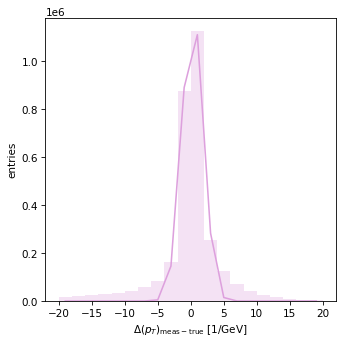

[INFO    ] # of entries: 477217, mean: -0.12754184089952086, std: 10.251226219050828
[INFO    ] gaus fit (a, mu, sig): [ 5.82350866e+04 -1.91705768e-01  5.94131236e+00]


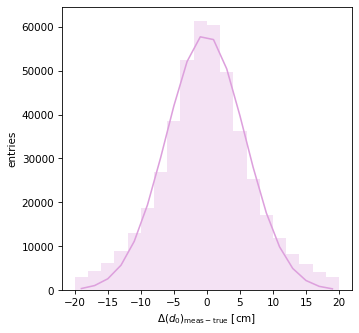

In [53]:
__generate_delta_plots__(model = pruned_model,
                        x = x,
                        y = y,
                        dxy = dxy,
                        color='plum',
                        bins_y = [-20.,20.],
                        bins_dxy = [-20.,20.],
                        batch_size = 4096,
                        min_y_val= 20.0)